# **Task 1:**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import cv2

# Load dataset
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize images to [0,1] range
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Resize if needed (optional)
x_train = tf.image.resize(x_train, (32, 32))
x_test = tf.image.resize(x_test, (32, 32))


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
x_train = x_train.numpy()
x_test = x_test.numpy()

def add_noise(img):
    noise = np.random.normal(loc=0, scale=0.1, size=img.shape)
    return np.clip(img + noise, 0, 1)

def add_blur(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

# Apply noise & blur to images
x_train_noisy = np.array([add_noise(img) for img in x_train])
x_test_noisy = np.array([add_noise(img) for img in x_test])

x_train_blurred = np.array([add_blur(img) for img in x_train])
x_test_blurred = np.array([add_blur(img) for img in x_test])

# Combine both degradations
x_train_degraded = np.clip((x_train_noisy + x_train_blurred) / 2, 0, 1)
x_test_degraded = np.clip((x_test_noisy + x_test_blurred) / 2, 0, 1)


In [5]:
def build_autoencoder():
    input_img = layers.Input(shape=(32, 32, 3))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(input_img, decoded)

autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
autoencoder.fit(x_train_degraded, x_train, epochs=10, batch_size=128, validation_data=(x_test_degraded, x_test))


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.0193 - val_loss: 0.0060
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0035 - val_loss: 0.0034


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Average PSNR: 24.8833242479557


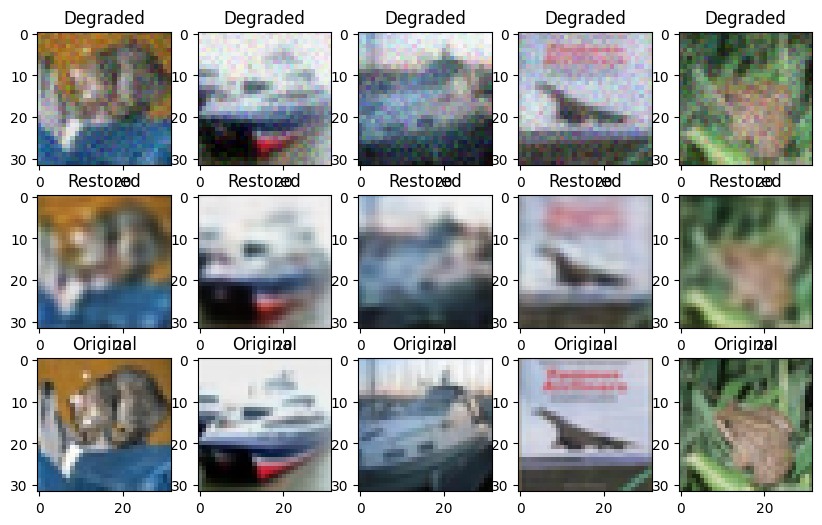

In [7]:
from skimage.metrics import peak_signal_noise_ratio as psnr

restored_images = autoencoder.predict(x_test_degraded)

# Evaluate PSNR
psnr_values = [psnr(x_test[i], restored_images[i]) for i in range(10)]
print("Average PSNR:", np.mean(psnr_values))

# Plot images
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.imshow(x_test_degraded[i])
    plt.title("Degraded")

    plt.subplot(3, n, i + 1 + n)
    plt.imshow(restored_images[i])
    plt.title("Restored")

    plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test[i])
    plt.title("Original")

plt.show()


# **Task 2:**

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


100%|██████████| 169M/169M [00:13<00:00, 12.4MB/s]


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

alexnet.classifier[6] = nn.Linear(4096, 100)
vgg16.classifier[6] = nn.Linear(4096, 100)

alexnet.to(device)
vgg16.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 145MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
def train_model(model, trainloader, criterion, optimizer, epochs=2):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

criterion = nn.CrossEntropyLoss()
optimizer_alexnet = optim.Adam(alexnet.parameters(), lr=0.001)
optimizer_vgg16 = optim.Adam(vgg16.parameters(), lr=0.001)

train_model(alexnet, trainloader, criterion, optimizer_alexnet)
train_model(vgg16, trainloader, criterion, optimizer_vgg16)


Epoch 1, Loss: 3.8372998115656625
Epoch 2, Loss: 3.1356024955544632
Epoch 1, Loss: 4.482842900259111
Epoch 2, Loss: 3.966593503037377


In [6]:
def evaluate_model(model, testloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

alexnet_acc = evaluate_model(alexnet, testloader)
vgg16_acc = evaluate_model(vgg16, testloader)

print(f"AlexNet Accuracy: {alexnet_acc:.2f}%")
print(f"VGG16 Accuracy: {vgg16_acc:.2f}%")


AlexNet Accuracy: 26.96%
VGG16 Accuracy: 13.02%
